# Augmentation Gallery

This example showcases different augmentations possible with DALI, using its new imperative mode.

With imperative mode, there's no need to build pipeline objects; we can simply use the operators as functions.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

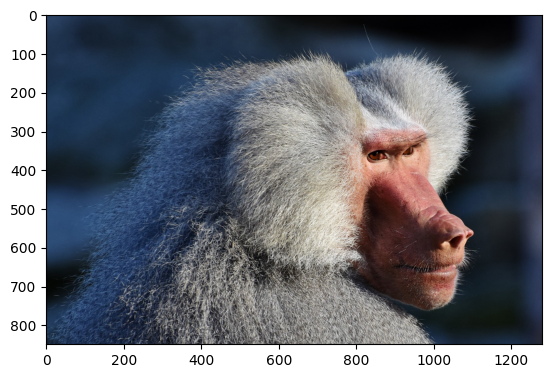

In [1]:
import nvidia.dali.experimental.dali2 as dali2
from nvidia.dali import types
import matplotlib.pyplot as plt
import math
import os.path
import numpy as np

test_data_root = os.environ["DALI_EXTRA_PATH"]
db_folder = os.path.join(test_data_root, "db", "lmdb")
reader = dali2.readers.Caffe(path=db_folder, random_shuffle=True, seed=100)
iterator = reader.samples()
encoded, label = next(iterator)
image = dali2.decoders.image(encoded, device="mixed", output_type=types.RGB)
plt.imshow(image.cpu().data)  # TODO(janton): .data shouldn't be needed.

In [2]:
augmentations = {}

# input is sampled randomly for output pixel's neighbourhood
augmentations["erase"] = dali2.erase(
    image,
    anchor=[0.3, 0.2],
    shape=[0.5, 0.6],
    normalized_anchor=True,
    normalized_shape=True,
    axis_names="HW",
)

augmentations["slice"] = dali2.slice(
    image, rel_start=[0.3, 0.2], rel_shape=[0.5, 0.6], axis_names="HW"
)

# transforms sampling coordinates to produce wavy patterns
augmentations["water"] = dali2.water(image)

# applies fisheye distortion
augmentations["sphere"] = dali2.sphere(image)

# rotates the image, enlarging the canvas
# TODO(janton): angle=30 doesn't work anymore. Fix this.
augmentations["rotate"] = dali2.rotate(
    image, angle=30.0, interp_type=types.INTERP_LINEAR, fill_value=0
)

# applies affine transform
augmentations["warp_affine"] = dali2.warp_affine(
    image,
    matrix=dali2.Tensor([[1.0, 0.8, 0.0,], [0.0, 1.2, 0.0]]),
    interp_type=types.INTERP_LINEAR,
)

# manipulates brightness and contrast of the image
augmentations["brightness_contrast"] = dali2.brightness_contrast(
    image, brightness=0.5, contrast=1.5
)

# Generate JPEG compression artifacts
augmentations["jpeg compression distortion"] = (
    dali2.jpeg_compression_distortion(image, quality=5)
)

# twists colors of the image
augmentations["hsv"] = dali2.hsv(image, hue=45.0, saturation=0.2)

# places the image on a larger canvas
augmentations["paste"] = dali2.paste(
    image, ratio=2.0, fill_value=(55, 155, 155), paste_x=0.1, paste_y=0.7
)

# param flips the image
augmentations["vertical and horizontal flip"] = dali2.flip(
    image, vertical=1, horizontal=1
)

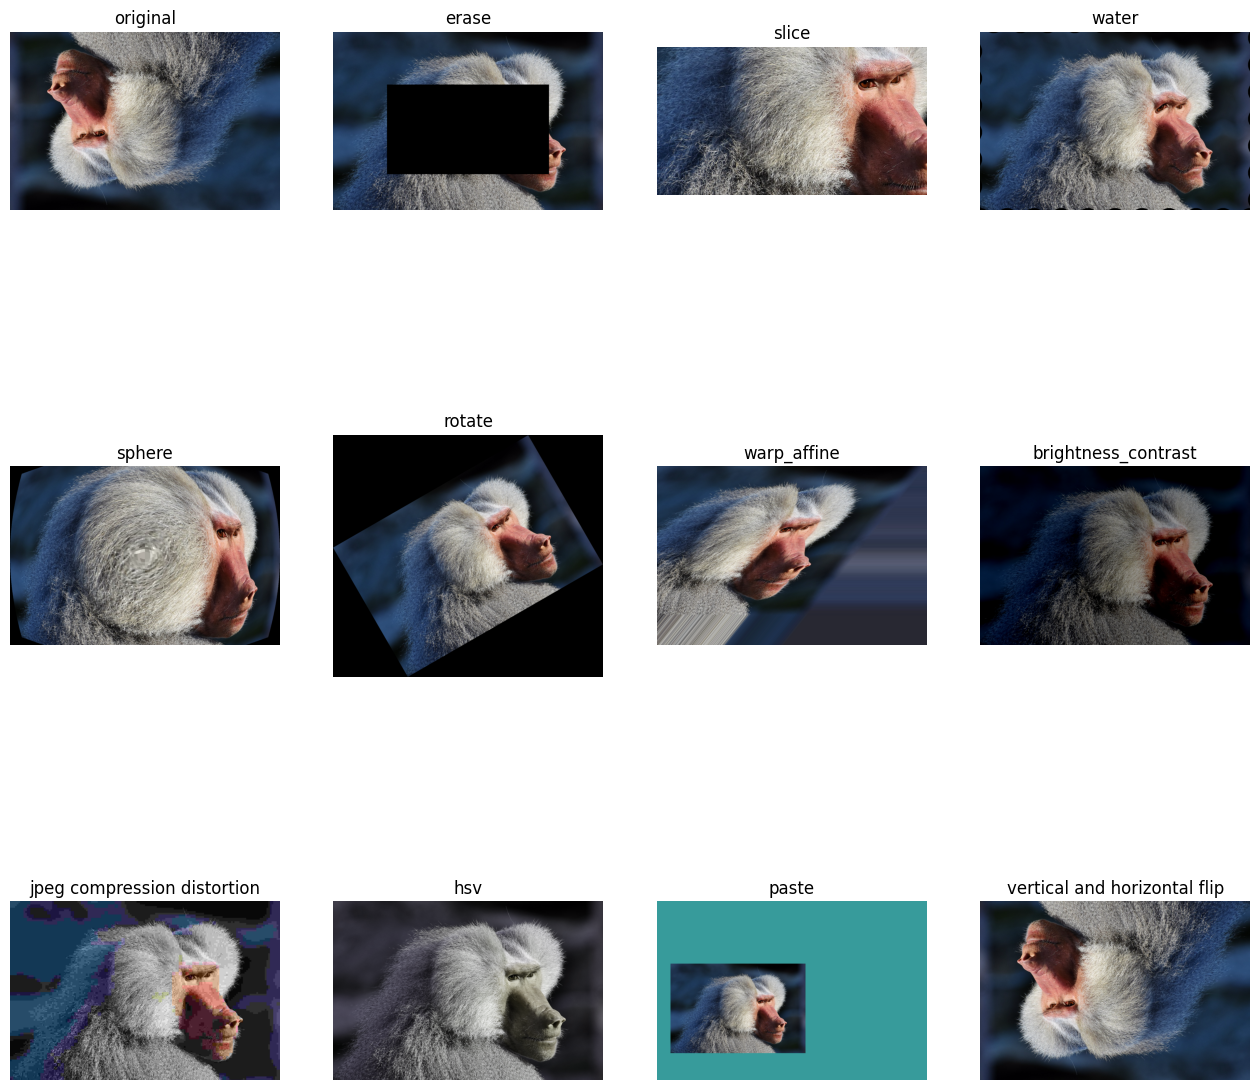

In [4]:
n = 5
import matplotlib.gridspec as gridspec
import numpy as np
titles = ["original"] + list(augmentations.keys())
images = [image] + [image for image in augmentations.values()]
N = len(titles)

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = int(math.ceil(N / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(N):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(titles[i])
    image = images[i].cpu()
    plt.imshow(image.data)